<a href="https://colab.research.google.com/github/trietp1253201581/KaggleCompetition/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook này chạy trên Colab.

# Dự đoán khả năng sống sót trên tàu Titanic

[Link_to_competition](https://www.kaggle.com/competitions/titanic)

## Exploring datasets

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [2]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from zipfile import ZipFile
with ZipFile(file='titanic.zip') as f:
    f.extractall(path='data')

In [4]:
import pandas as pd

In [5]:
raw_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sub_df = pd.read_csv('data/gender_submission.csv')

In [6]:
raw_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
target_col = 'Survived'
input_cols = raw_df.columns[2:].tolist()

In [8]:
input_cols

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [9]:
raw_df[input_cols].isna().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Age

In [10]:
raw_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
avg_age = raw_df['Age'].mean()
avg_age

29.69911764705882

In [12]:
raw_df.fillna({'Age': avg_age}, inplace=True)

In [13]:
raw_df['AgeGroup'] = pd.cut(raw_df['Age'],
                            bins=[-1,5,14,18,30,60,100],
                            labels=['Baby','Child','Teenager','Adult','OldAdult','Old'])

In [14]:
test_df.fillna({'Age': avg_age}, inplace=True)
test_df['AgeGroup'] = pd.cut(test_df['Age'],
                            bins=[-1,5,14,18,30,60,100],
                            labels=['Baby','Child','Teenager','Adult','OldAdult','Old'])

### Name

In [15]:
raw_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [16]:
import numpy as np

In [17]:
def sub_in_str(s, sub_strs: list[str]):
    st = str(s)
    for sub_str in sub_strs:
        if st.find(sub_str) != -1:
            return sub_str
    return np.nan

In [18]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

In [19]:
raw_df['Title'] = raw_df['Name'].apply(lambda x: sub_in_str(x, title_list))

In [20]:
test_df['Title'] = test_df['Name'].apply(lambda x: sub_in_str(x, title_list))

In [21]:
raw_df['Title'].value_counts()

Title
Mr          518
Miss        180
Mrs         129
Master       40
Dr            7
Rev           6
Major         2
Col           2
Don           1
Mme           1
Ms            1
Mlle          1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [22]:
def replace_title(x):
    title = x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    if title in ['Countess', 'Mme']:
        return 'Mrs'
    if title in ['Mlle', 'Ms']:
        return 'Miss'
    if title == 'Dr':
        if x['Sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    return title

In [23]:
raw_df['Title'] = raw_df.apply(replace_title, axis=1)

In [24]:
test_df['Title'] = test_df.apply(replace_title, axis=1)

In [25]:
raw_df['Title'].value_counts(dropna=False)

Title
Mr        531
Miss      182
Mrs       138
Master     40
Name: count, dtype: int64

In [26]:
test_df['Title'].value_counts(dropna=False)

Title
Mr        245
Miss       79
Mrs        73
Master     21
Name: count, dtype: int64

### Cabin

In [27]:
raw_df['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [28]:
deck_lst = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'UNK']
raw_df['Deck'] = raw_df['Cabin'].apply(lambda x: sub_in_str(x, deck_lst))

In [29]:
raw_df['Deck'].value_counts(dropna=False)

Deck
NaN    687
C       59
B       47
E       33
D       33
A       15
F       12
G        4
T        1
Name: count, dtype: int64

In [30]:
raw_df['Deck'].fillna('UNK', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_11192\3661949292.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_df['Deck'].fillna('UNK', inplace=True)


In [31]:
raw_df['Deck'].value_counts(dropna=False)

Deck
UNK    687
C       59
B       47
E       33
D       33
A       15
F       12
G        4
T        1
Name: count, dtype: int64

In [32]:
test_df['Deck'] = test_df['Cabin'].apply(lambda x: sub_in_str(x, deck_lst))
test_df['Deck'].fillna('UNK', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_11192\1854043941.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Deck'].fillna('UNK', inplace=True)


In [33]:
test_df['Deck'].value_counts(dropna=False)

Deck
UNK    327
C       35
B       18
D       13
E       11
A        7
F        6
G        1
Name: count, dtype: int64

### Embarked

In [34]:
raw_df['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [35]:
raw_df['Embarked'] = raw_df['Embarked'].fillna('S')

In [36]:
raw_df['Embarked'].value_counts(dropna=False)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

### Fare

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
raw_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

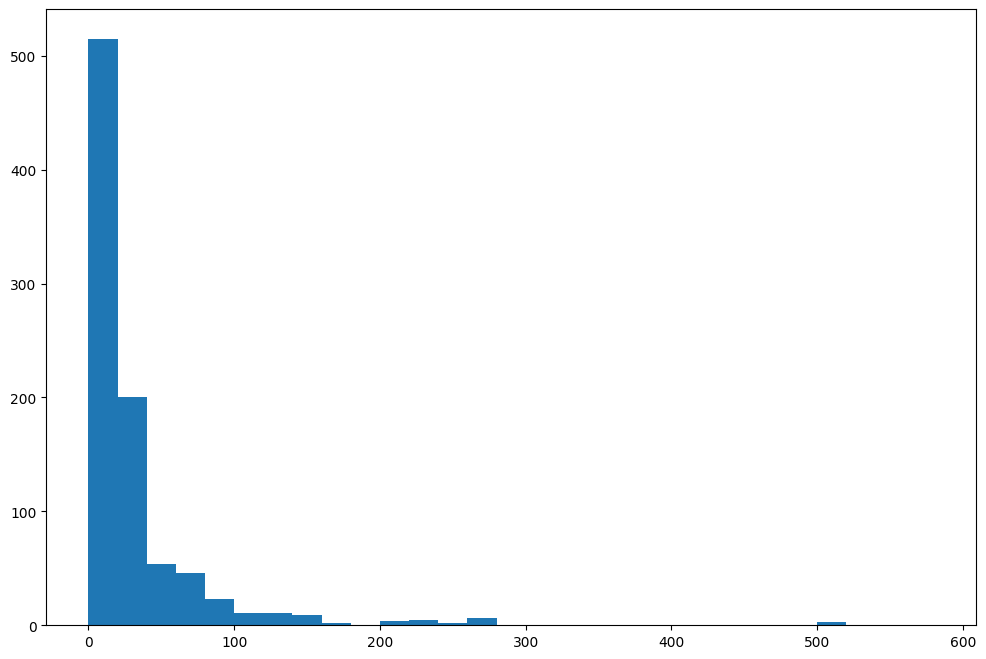

In [39]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['Fare'], bins=np.arange(0,600,20));

In [40]:
raw_df['LowFare'] = raw_df['Fare'].apply(lambda x: 1 if x<=32 else 0)

In [41]:
raw_df['LowFare'].value_counts(dropna=False)

LowFare
1    680
0    211
Name: count, dtype: int64

In [42]:
test_df['LowFare'] = test_df['Fare'].apply(lambda x: 1 if x<=32 else 0)

### SibSp, Parch

In [43]:
raw_df[['SibSp', 'Parch']]

,SibSp,Parch
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
886,0,0
887,0,0
888,1,2
889,0,0


In [44]:
raw_df['FamilySize'] = raw_df['SibSp'] + raw_df['Parch']

In [45]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']

In [46]:
raw_df['FamilySize'].value_counts()

FamilySize
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64

In [47]:
raw_df['IsAlone'] = raw_df['FamilySize'].apply(lambda x: 1 if x==0 else 0)

In [48]:
test_df['IsAlone'] = test_df['FamilySize'].apply(lambda x: 1 if x==0 else 0)

In [49]:
raw_df['IsAlone'].value_counts()

IsAlone
1    537
0    354
Name: count, dtype: int64

### Interactive Feature

In [50]:
raw_df['FarePerMember'] = raw_df['Fare']/(raw_df['FamilySize']+1)

In [51]:
test_df['FarePerMember'] = test_df['Fare']/(test_df['FamilySize']+1)

In [52]:
raw_df['FarePerMember'].describe()

count    891.000000
mean      19.916375
std       35.841257
min        0.000000
25%        7.250000
50%        8.300000
75%       23.666667
max      512.329200
Name: FarePerMember, dtype: float64

In [53]:
raw_df['Fare*Pclass'] = raw_df['Fare']*raw_df['Pclass']
raw_df['Fare*Pclass']

0      21.7500
1      71.2833
2      23.7750
3      53.1000
4      24.1500
        ...   
886    26.0000
887    30.0000
888    70.3500
889    30.0000
890    23.2500
Name: Fare*Pclass, Length: 891, dtype: float64

In [54]:
raw_df['Fare*Pclass'].describe()

count    891.000000
mean      51.543413
std       51.577796
min        0.000000
25%       23.687400
50%       28.500000
75%       58.000000
max      512.329200
Name: Fare*Pclass, dtype: float64

In [55]:
test_df['Fare*Pclass'] = test_df['Fare'] * test_df['Pclass']

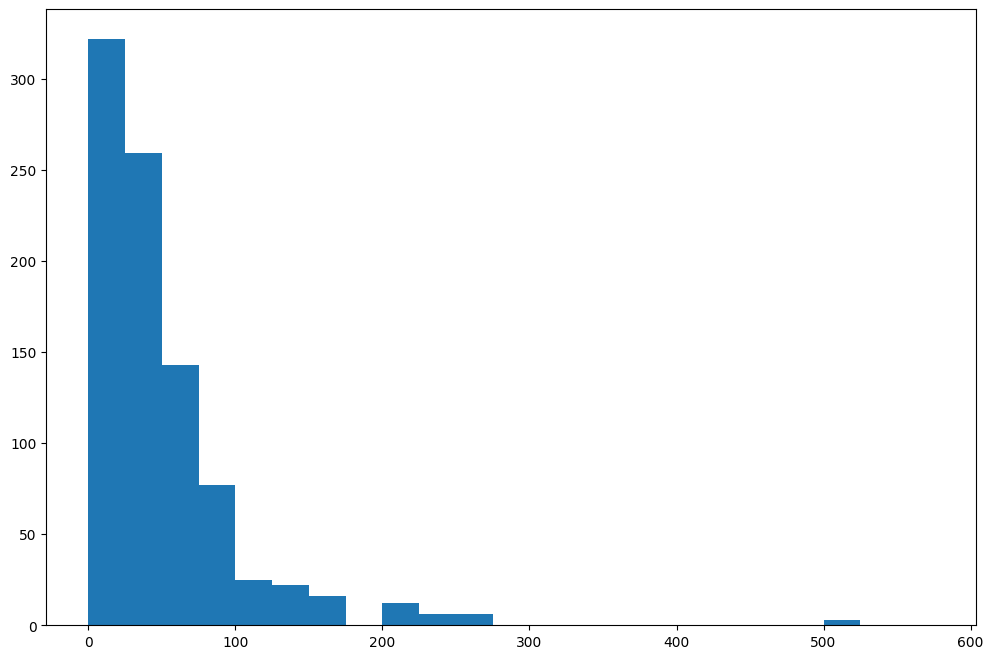

In [56]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['Fare*Pclass'], bins=np.arange(0,600,25));

In [57]:
raw_df['logFare'] = raw_df['Fare'].apply(lambda x: np.log(x) if x>0 else 0)

In [58]:
test_df['logFare'] = test_df['Fare'].apply(lambda x: np.log(x) if x>0 else 0)

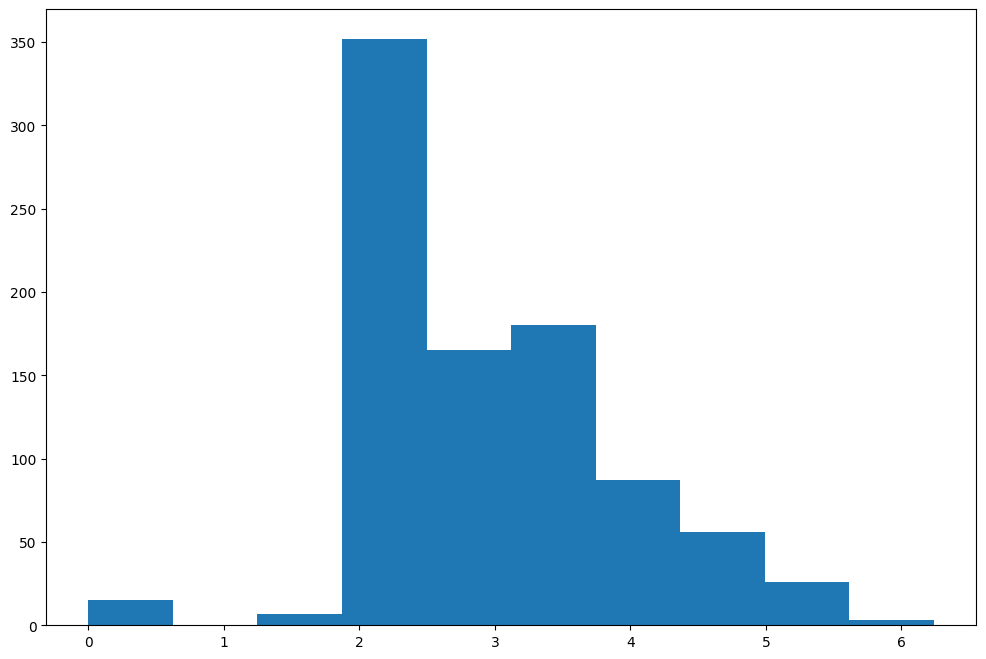

In [59]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['logFare'], bins=10);

In [60]:
raw_df['Age*Pclass'] = raw_df['Age'] * raw_df['Pclass']

In [61]:
test_df['Age*Pclass'] = test_df['Age'] * test_df['Pclass']

In [62]:
raw_df['logAge'] = raw_df['Age'].apply(lambda x: np.log(x) if x>=1 else 0)

In [63]:
test_df['logAge'] = test_df['Age'].apply(lambda x: np.log(x) if x>=1 else 0)

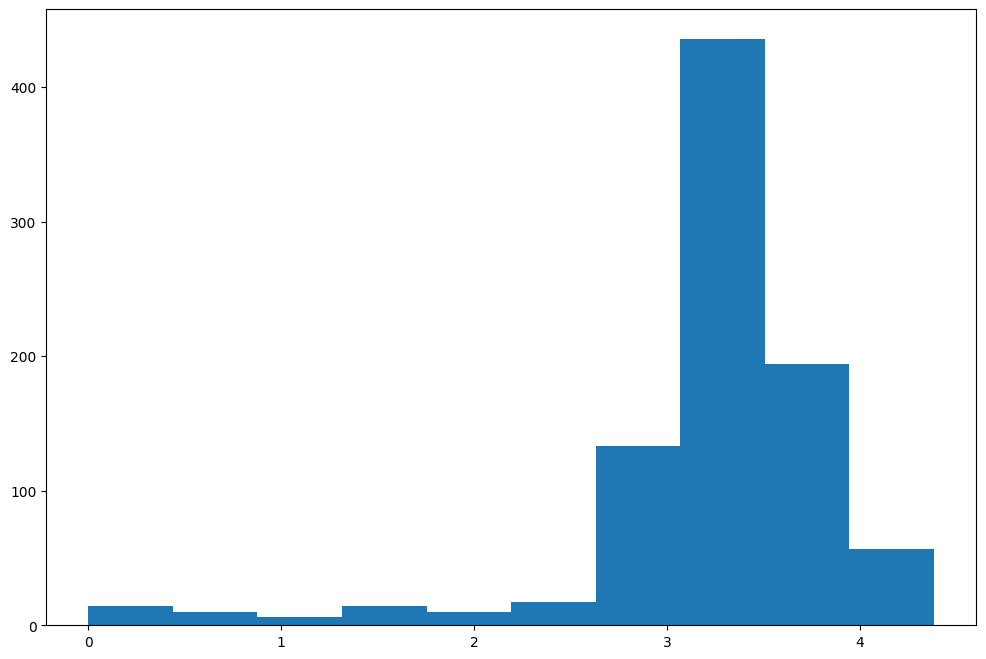

In [64]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['logAge'], bins=10);

## Preprocessing

In [65]:
raw_df.drop(columns='PassengerId', inplace=True)

In [66]:
raw_df.drop(columns=['Name','Ticket'], inplace=True)

In [67]:
raw_df.drop(columns='Cabin', inplace=True)

In [68]:
raw_df.isna().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
AgeGroup         0
Title            0
Deck             0
LowFare          0
FamilySize       0
IsAlone          0
FarePerMember    0
Fare*Pclass      0
logFare          0
Age*Pclass       0
logAge           0
dtype: int64

### Scaler

In [69]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'LowFare',
 'FamilySize',
 'IsAlone',
 'FarePerMember',
 'Fare*Pclass',
 'logFare',
 'Age*Pclass',
 'logAge']

In [70]:
numeric_cols.remove('Pclass')
numeric_cols.remove('LowFare')
numeric_cols.remove('IsAlone')
numeric_cols.remove('Survived')

In [71]:
numeric_cols

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'FamilySize',
 'FarePerMember',
 'Fare*Pclass',
 'logFare',
 'Age*Pclass',
 'logAge']

In [72]:
from sklearn.preprocessing import StandardScaler

In [73]:
scaler = StandardScaler()
scaler.fit(raw_df[numeric_cols])

StandardScaler()

In [74]:
raw_df[numeric_cols] = scaler.transform(raw_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [75]:
raw_df[numeric_cols].describe()

,Age,SibSp,Parch,Fare,FamilySize,FarePerMember,Fare*Pclass,logFare,Age*Pclass,logAge
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,2.232906e-16,4.386066e-17,5.382900e-17,3.987333e-18,-3.987333e-18,-2.990500e-17,1.794300e-16,-6.828308e-17,-1.305852e-16,1.555060e-16
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-2.253155e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-5.609748e-01,-5.559950e-01,-9.998946e-01,-2.887102e+00,-1.944995e+00,-4.668910e+00
25%,-5.924806e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-5.609748e-01,-3.536006e-01,-5.403809e-01,-8.237453e-01,-7.582004e-01,-2.107800e-01
50%,0.000000e+00,-4.745452e-01,-4.736736e-01,-3.573909e-01,-5.609748e-01,-3.242883e-01,-4.470209e-01,-2.223418e-01,-5.972894e-02,2.220102e-01
75%,4.079260e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,5.915988e-02,1.046949e-01,1.252518e-01,5.388821e-01,7.328040e-01,4.588759e-01
max,3.870872e+00,6.784163e+00,6.974147e+00,9.667167e+00,5.640372e+00,1.374643e+01,8.938819e+00,3.337325e+00,4.768835e+00,1.651173e+00


### Encoder

In [76]:
categorical_cols = raw_df.select_dtypes(exclude=np.number).columns.tolist()
categorical_cols

['Sex', 'Embarked', 'AgeGroup', 'Title', 'Deck']

In [77]:
categorical_cols.append('Pclass')
categorical_cols.append('LowFare')
categorical_cols.append('IsAlone')

In [78]:
from sklearn.preprocessing import OneHotEncoder

In [79]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [80]:
encoder.fit(raw_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [81]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
len(encoded_cols)

31

In [82]:
encoded_df = pd.DataFrame(data=encoder.transform(raw_df[categorical_cols]), columns=encoded_cols)
encoded_df.index = raw_df.index
raw_df = pd.concat([raw_df, encoded_df], axis=1).copy()

In [83]:
encoded_df = pd.DataFrame(data=encoder.transform(test_df[categorical_cols]), columns=encoded_cols)
encoded_df.index = test_df.index
test_df = pd.concat([test_df, encoded_df], axis=1).copy()

In [84]:
inputs = raw_df[numeric_cols+encoded_cols]
targets = raw_df['Survived']

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets,
                                                                        test_size=0.2,
                                                                        random_state=42)

In [87]:
train_inputs.shape

(712, 41)

In [88]:
val_inputs.shape

(179, 41)

In [89]:
test_inputs = test_df[numeric_cols+encoded_cols]

## Feature Selection

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [91]:
rf = RandomForestClassifier()

In [92]:
acc_rf = cross_val_score(rf, inputs, targets, scoring='accuracy', cv=5).mean()
acc_rf

0.8215742891218379

In [93]:
rf.fit(train_inputs, train_targets)

RandomForestClassifier()

In [94]:
rf.score(val_inputs, val_targets)

0.8156424581005587

In [95]:
feature_importance_map = {}
name = rf.feature_names_in_
importance = rf.feature_importances_
for i in range(len(name)):
    feature_importance_map[name[i]] = importance[i]

In [96]:
def test_importance(threshold: float):
    importance_features = []
    for name, importance in feature_importance_map.items():
        if importance >= threshold:
            importance_features.append(name)
    importance_features.remove('Age')
    importance_features.remove('Fare')
    rf = RandomForestClassifier()
    rf.fit(train_inputs[importance_features], train_targets)
    return rf.score(val_inputs[importance_features], val_targets), importance_features

In [97]:
score, importance_features = test_importance(0.005)
score

0.8268156424581006

In [98]:
len(importance_features)

27

In [99]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [100]:
classifier = {
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'LGBM': LGBMClassifier()
}
result = {'Classifier': [], 'Accuracy': []}

In [101]:
for clf_name, clf in classifier.items():
    clf.fit(train_inputs[importance_features], train_targets)
    acc = clf.score(val_inputs[importance_features], val_targets)
    result['Classifier'].append(clf_name)
    result['Accuracy'].append(acc)
result_df = pd.DataFrame(result)
result_df

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Classifier,Accuracy
0,RF,0.837989
1,XGB,0.810056
2,LGBM,0.826816


In [102]:
def test_params(**params):
    model = RandomForestClassifier(**params)
    model.fit(train_inputs[importance_features], train_targets)
    train_acc = model.score(train_inputs[importance_features], train_targets)
    val_acc = model.score(val_inputs[importance_features], val_targets)
    return train_acc, val_acc

In [103]:
test_params(n_jobs=-1)

(0.9845505617977528, 0.8379888268156425)

In [104]:
for i in [50, 70, 90, 110, 130, 200]:
    train_acc, val_acc = test_params(n_jobs=-1, n_estimators=i)
    print("Test {}: train_acc = {:6f}, val_acc = {:6f}".format(i, train_acc, val_acc))

Test 50: train_acc = 0.984551, val_acc = 0.860335
Test 70: train_acc = 0.983146, val_acc = 0.832402
Test 90: train_acc = 0.984551, val_acc = 0.832402
Test 110: train_acc = 0.984551, val_acc = 0.821229
Test 130: train_acc = 0.984551, val_acc = 0.832402
Test 200: train_acc = 0.984551, val_acc = 0.843575


In [105]:
for i in [None, 18, 24, 30, 36, 42]:
    train_acc, val_acc = test_params(n_jobs=-1, n_estimators=110,
                                     max_depth=i)
    print("Test {}: train_acc = {:6f}, val_acc = {:6f}".format(i, train_acc, val_acc))

Test None: train_acc = 0.984551, val_acc = 0.832402
Test 18: train_acc = 0.984551, val_acc = 0.843575
Test 24: train_acc = 0.984551, val_acc = 0.826816
Test 30: train_acc = 0.984551, val_acc = 0.826816
Test 36: train_acc = 0.984551, val_acc = 0.826816
Test 42: train_acc = 0.984551, val_acc = 0.837989


In [106]:
for i in ["gini", "entropy", "log_loss"]:
    train_acc, val_acc = test_params(n_jobs=-1, n_estimators=110,
                                     max_depth=24, criterion=i)
    print("Test {}: train_acc = {:6f}, val_acc = {:6f}".format(i, train_acc, val_acc))

Test gini: train_acc = 0.984551, val_acc = 0.837989
Test entropy: train_acc = 0.984551, val_acc = 0.832402
Test log_loss: train_acc = 0.984551, val_acc = 0.832402


In [107]:
for i in [None, 0, 42, 1212]:
    train_acc, val_acc = test_params(n_jobs=-1, n_estimators=110,
                                     max_depth=24, criterion='entropy',
                                     random_state=i)
    print("Test {}: train_acc = {:6f}, val_acc = {:6f}".format(i, train_acc, val_acc))

Test None: train_acc = 0.984551, val_acc = 0.849162
Test 0: train_acc = 0.984551, val_acc = 0.832402
Test 42: train_acc = 0.984551, val_acc = 0.843575
Test 1212: train_acc = 0.984551, val_acc = 0.837989


In [108]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42,
                                  n_estimators=110, max_depth=24,
                                  criterion='entropy')

In [109]:
rf_model.fit(train_inputs[importance_features], train_targets)

RandomForestClassifier(criterion='entropy', max_depth=24, n_estimators=110,
                       n_jobs=-1, random_state=42)

In [110]:
rf_model.score(val_inputs[importance_features], val_targets)

0.8435754189944135

In [111]:
preds = rf_model.predict(test_inputs[importance_features])

In [112]:
sub_df['Survived'] = preds
sub_df.to_csv('data/sub1.csv', index=None)